# Models Comparison for TinyML

In [39]:
# Load libraries
import numpy as np
from numpy import arange
import pickle
#
import matplotlib.pyplot as plt

#
import pandas as pd
from pandas import read_csv

from sklearn.metrics import confusion_matrix,  classification_report, f1_score
from sklearn.model_selection import train_test_split, KFold,StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline

from keras.models import Sequential, Model 
from keras.layers import Dense, Input, concatenate, Activation, Dropout
from keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

import tensorflow
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from micromlgen import port
import tinymlgen as tiny

import warnings
import seaborn as sbs
import sys

warnings.filterwarnings('ignore')

In [40]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tensorflow.random.set_seed(RANDOM_SEED)
np.set_printoptions(threshold=sys.maxsize)
tasks = ["2Labels", "3Labels", "4Labels", "5Labels"]
# Change this to change subtask
taskIndex = 0

In [41]:
with open('data/X.pkl', 'rb') as f:
    X = pickle.load(f)

with open('data/y.pkl', 'rb') as f:
    y = pickle.load(f)

In [42]:
n_labels = 2 + taskIndex
samples = 100
X = X[:n_labels*samples]
y = y[:n_labels*samples]
labels = np.unique(y)

In [43]:
classes = np.unique(y).tolist()
for i in range(len(classes)):
    y = np.where(y==classes[i], i, y)

In [44]:
y = np.array([int(el) for el in y])
print(y)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED)
print(X_test.shape)
print(y_test.shape)


(40, 42)
(40,)


In [46]:
X_test

array([[ 0.09,  0.02,  0.94,  0.07, -0.08,  0.96,  0.03, -0.05,  1.04,
         0.12,  0.07,  1.07,  0.08, -0.09,  0.72,  0.11, -0.12,  0.88,
         0.09, -0.23,  1.06,  0.1 , -0.03,  0.96,  0.08, -0.09,  0.98,
         0.08, -0.13,  0.98,  0.07, -0.15,  0.96,  0.11, -0.15,  0.96,
         0.07, -0.12,  1.01,  0.04, -0.27,  0.95],
       [-0.  ,  0.01,  0.97, -0.03,  0.06,  0.97, -0.08, -0.07,  1.32,
        -0.05, -0.38,  0.92,  0.11, -0.06,  0.73,  0.16,  0.24,  0.83,
         0.06,  0.11,  1.07,  0.03,  0.13,  1.07, -0.02,  0.04,  0.99,
        -0.08, -0.06,  0.93, -0.06,  0.02,  0.99, -0.04,  0.02,  1.  ,
        -0.02,  0.02,  0.98, -0.02,  0.  ,  0.98],
       [ 0.08,  0.03,  1.03,  0.05, -0.02,  0.98,  0.13,  0.35,  1.02,
         0.1 , -0.07,  1.15,  0.1 , -0.18,  1.01,  0.15,  0.07,  0.7 ,
         0.26,  0.2 ,  0.73,  0.15,  0.2 ,  0.93,  0.08,  0.21,  1.13,
        -0.  , -0.06,  1.  ,  0.04,  0.02,  1.04,  0.07, -0.03,  0.96,
         0.07,  0.01,  1.01,  0.07, -0.05,  0.

In [47]:
y_test

array([0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0])

## Model Spotting

In [48]:
# Test options and evaluation metric
num_folds = 5
seed = 42
scoring = 'f1_macro'

In [49]:
# Spot-Check Algorithms
models = []

#models.append(('XGB', XGBClassifier(random_state=seed)))
models.append(('GNB', GaussianNB(var_smoothing=2e-9)))
models.append(('LR', LogisticRegression(random_state=seed)))
models.append(('CART' , DecisionTreeClassifier(random_state=seed)))
models.append(('SVC' , SVC(gamma=0.99, random_state=seed)))
models.append(('RF', RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=100, 
                                                           max_features=5, criterion='gini', max_depth=None,
                                                           min_samples_split=4, min_samples_leaf=1)))


In [50]:
# Cross Validation
results = []
names = []
for name, model in models:
    # Dividere dati in n = num_folds
    kf = StratifiedKFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = np.array([])
    for train_idx, test_idx, in kf.split(X_train, y_train):
        X_cross_train, y_cross_train = X_train[train_idx], y_train[train_idx]
        X_cross_test, y_cross_test = X_train[test_idx], y_train[test_idx]
        model.fit(X_cross_train, y_cross_train)  
        y_pred = model.predict(X_cross_test)
        f1s = f1_score(y_cross_test, y_pred, average="weighted")
        cv_results = np.append(cv_results, [f1s])
    results.append(cv_results)
    names.append(name)
    #msg = "%s - %f - %f" % (name, cv_results.mean(), cv_results.std())
    msg = "{} - {:.2f} {:.2f}".format(name, cv_results.mean(), cv_results.std()).replace('.', ',')
    print(msg)

GNB - 0,94 0,04
LR - 0,95 0,03
CART - 0,86 0,03
SVC - 0,99 0,02
RF - 0,96 0,03


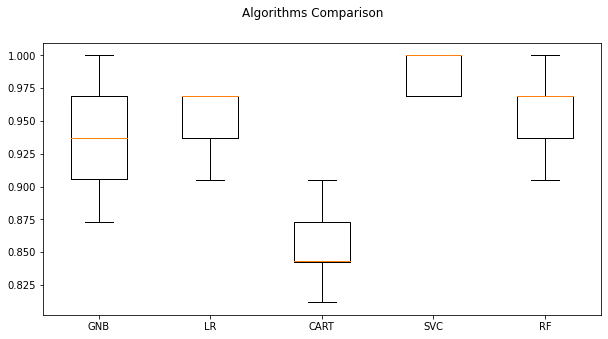

In [51]:
# Compare Algorithms
fig = plt.figure(figsize=(10,5))
fig.suptitle('Algorithms Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Valutazione dei migliori algoritmi su test

## Valutazione modelli sul Test Set

In [52]:
def classification_report_csv(report, model_name):
    report_data = []
    lines = report.split('\n')
    index = 0
    row = lines[-4].split('    ')
    accuracy = row[-2] if taskIndex > 1 else row[-3]
    for line in lines[2:-5]:
        row = {}
        row_data = line.split('      ')
        row['class'] = labels[index]
        row['precision'] = float(row_data[2]) 
        row['recall'] = float(row_data[3]) 
        row['f1_score'] = float(row_data[4])
        row['accuracy'] = accuracy
        report_data.append(row)
        index += 1
    dataframe = pd.DataFrame.from_dict(report_data)
    dataframe.to_csv(tasks[taskIndex] + "/classificationReports/" +'report' + model_name +  '.csv', index = False)
    
for name, model in models:
    model.fit(X_train,  y_train)
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    print(f"Model {name}: ")
    report = classification_report(y_test, pred_test)
    print(report)
    #classification_report_csv(report, name)
    print("-------------------------------------------------------------")

Model GNB: 
              precision    recall  f1-score   support

           0       0.95      1.00      0.98        20
           1       1.00      0.95      0.97        20

    accuracy                           0.97        40
   macro avg       0.98      0.97      0.97        40
weighted avg       0.98      0.97      0.97        40

-------------------------------------------------------------
Model LR: 
              precision    recall  f1-score   support

           0       0.87      1.00      0.93        20
           1       1.00      0.85      0.92        20

    accuracy                           0.93        40
   macro avg       0.93      0.93      0.92        40
weighted avg       0.93      0.93      0.92        40

-------------------------------------------------------------
Model CART: 
              precision    recall  f1-score   support

           0       0.86      0.95      0.90        20
           1       0.94      0.85      0.89        20

    accuracy          

# Neural Network

In [53]:
#Hyperparameters of NN
EPOCHS = 500 
BATCH_SIZE = 7
learn_rate = 0.001
nodes = 256
def getNetwork():
    model = Sequential(name="Sequential-NN")
    model.add(layers.Dense(X.shape[1], activation='relu', input_shape=(X.shape[1],)))
    model.add(layers.Dropout(0.25))    
    model.add(layers.Dense(nodes, activation='relu'))
    model.add(layers.Dropout(0.25))
    model.add(layers.Dense(np.unique(y).size, activation='softmax'))
    opt = Adam(learning_rate=learn_rate)
    # SGB
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

## Cross Validation NN

In [54]:
num_folds = 5
kf = StratifiedKFold(n_splits=num_folds, random_state=seed, shuffle=True)
cv_results = np.array([])
for train_idx, test_idx, in kf.split(X_train, y_train):
    X_cross_train, y_cross_train = X_train[train_idx], y_train[train_idx]
    
    X_cross_test, y_cross_test = X_train[test_idx], y_train[test_idx]
 
    model = getNetwork()
    model.fit(X_cross_train, y_cross_train, epochs=EPOCHS, batch_size=BATCH_SIZE)  
    y_pred = model.predict(X_cross_test)
    predictions_categorical = np.argmax(y_pred, axis=1)
    f1s = f1_score(y_cross_test, predictions_categorical, average="weighted")
    cv_results = np.append(cv_results, [f1s])

print(f'Average score of Cross Validation: {cv_results.mean()}')

Model: "Sequential-NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 42)                1806      
_________________________________________________________________
dropout_4 (Dropout)          (None, 42)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               11008     
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 514       
Total params: 13,328
Trainable params: 13,328
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
19/19 [==============================] - 0s 564us/step - loss: 0.6785 - accuracy: 0.5469
Epoch 2/500
19

19/19 [==============================] - 0s 617us/step - loss: 0.0055 - accuracy: 1.0000
Epoch 72/500
19/19 [==============================] - 0s 483us/step - loss: 0.0019 - accuracy: 1.0000
Epoch 73/500
19/19 [==============================] - 0s 597us/step - loss: 0.0042 - accuracy: 1.0000
Epoch 74/500
19/19 [==============================] - 0s 582us/step - loss: 0.0036 - accuracy: 1.0000
Epoch 75/500
19/19 [==============================] - 0s 574us/step - loss: 0.0030 - accuracy: 1.0000
Epoch 76/500
19/19 [==============================] - 0s 543us/step - loss: 0.0034 - accuracy: 1.0000
Epoch 77/500
19/19 [==============================] - 0s 517us/step - loss: 0.0113 - accuracy: 1.0000
Epoch 78/500
19/19 [==============================] - 0s 607us/step - loss: 0.0051 - accuracy: 1.0000
Epoch 79/500
19/19 [==============================] - 0s 554us/step - loss: 0.0035 - accuracy: 1.0000
Epoch 80/500
19/19 [==============================] - 0s 558us/step - loss: 0.0058 - accuracy: 

19/19 [==============================] - 0s 526us/step - loss: 0.0018 - accuracy: 1.0000
Epoch 151/500
19/19 [==============================] - 0s 533us/step - loss: 5.5734e-04 - accuracy: 1.0000
Epoch 152/500
19/19 [==============================] - 0s 506us/step - loss: 2.2097e-04 - accuracy: 1.0000
Epoch 153/500
19/19 [==============================] - 0s 578us/step - loss: 2.0479e-04 - accuracy: 1.0000
Epoch 154/500
19/19 [==============================] - 0s 565us/step - loss: 4.2026e-04 - accuracy: 1.0000
Epoch 155/500
19/19 [==============================] - 0s 580us/step - loss: 5.0641e-04 - accuracy: 1.0000
Epoch 156/500
19/19 [==============================] - 0s 476us/step - loss: 3.2320e-04 - accuracy: 1.0000
Epoch 157/500
19/19 [==============================] - 0s 549us/step - loss: 2.2127e-04 - accuracy: 1.0000
Epoch 158/500
19/19 [==============================] - 0s 529us/step - loss: 5.3114e-04 - accuracy: 1.0000
Epoch 159/500
19/19 [==============================] - 

19/19 [==============================] - 0s 585us/step - loss: 5.3551e-04 - accuracy: 1.0000
Epoch 229/500
19/19 [==============================] - 0s 559us/step - loss: 2.6902e-04 - accuracy: 1.0000
Epoch 230/500
19/19 [==============================] - 0s 477us/step - loss: 1.6630e-04 - accuracy: 1.0000
Epoch 231/500
19/19 [==============================] - 0s 552us/step - loss: 0.0017 - accuracy: 1.0000
Epoch 232/500
19/19 [==============================] - 0s 584us/step - loss: 9.4302e-04 - accuracy: 1.0000
Epoch 233/500
19/19 [==============================] - 0s 543us/step - loss: 0.0055 - accuracy: 1.0000
Epoch 234/500
19/19 [==============================] - 0s 501us/step - loss: 0.0040 - accuracy: 1.0000
Epoch 235/500
19/19 [==============================] - 0s 564us/step - loss: 4.4583e-04 - accuracy: 1.0000
Epoch 236/500
19/19 [==============================] - 0s 560us/step - loss: 0.0010 - accuracy: 1.0000
Epoch 237/500
19/19 [==============================] - 0s 548us/ste

19/19 [==============================] - 0s 518us/step - loss: 0.0300 - accuracy: 0.9922
Epoch 306/500
19/19 [==============================] - 0s 567us/step - loss: 0.0278 - accuracy: 0.9922
Epoch 307/500
19/19 [==============================] - 0s 574us/step - loss: 0.0094 - accuracy: 0.9922
Epoch 308/500
19/19 [==============================] - 0s 589us/step - loss: 0.0234 - accuracy: 0.9844
Epoch 309/500
19/19 [==============================] - 0s 598us/step - loss: 0.0136 - accuracy: 0.9922
Epoch 310/500
19/19 [==============================] - 0s 536us/step - loss: 0.0225 - accuracy: 0.9922
Epoch 311/500
19/19 [==============================] - 0s 528us/step - loss: 0.0145 - accuracy: 0.9922
Epoch 312/500
19/19 [==============================] - 0s 618us/step - loss: 0.0015 - accuracy: 1.0000
Epoch 313/500
19/19 [==============================] - 0s 575us/step - loss: 0.0052 - accuracy: 1.0000
Epoch 314/500
19/19 [==============================] - 0s 550us/step - loss: 0.0020 - a

19/19 [==============================] - 0s 565us/step - loss: 1.5659e-04 - accuracy: 1.0000
Epoch 383/500
19/19 [==============================] - 0s 554us/step - loss: 1.8962e-04 - accuracy: 1.0000
Epoch 384/500
19/19 [==============================] - 0s 520us/step - loss: 0.0048 - accuracy: 1.0000
Epoch 385/500
19/19 [==============================] - 0s 601us/step - loss: 2.3469e-05 - accuracy: 1.0000
Epoch 386/500
19/19 [==============================] - 0s 601us/step - loss: 0.0046 - accuracy: 1.0000
Epoch 387/500
19/19 [==============================] - 0s 560us/step - loss: 2.4085e-05 - accuracy: 1.0000
Epoch 388/500
19/19 [==============================] - 0s 507us/step - loss: 0.0044 - accuracy: 1.0000
Epoch 389/500
19/19 [==============================] - 0s 579us/step - loss: 2.4025e-04 - accuracy: 1.0000
Epoch 390/500
19/19 [==============================] - 0s 560us/step - loss: 0.0022 - accuracy: 1.0000
Epoch 391/500
19/19 [==============================] - 0s 601us/ste

19/19 [==============================] - 0s 562us/step - loss: 1.3879e-04 - accuracy: 1.0000
Epoch 460/500
19/19 [==============================] - 0s 569us/step - loss: 7.9529e-05 - accuracy: 1.0000
Epoch 461/500
19/19 [==============================] - 0s 505us/step - loss: 8.3090e-05 - accuracy: 1.0000
Epoch 462/500
19/19 [==============================] - 0s 540us/step - loss: 4.4032e-04 - accuracy: 1.0000
Epoch 463/500
19/19 [==============================] - 0s 583us/step - loss: 2.4514e-04 - accuracy: 1.0000
Epoch 464/500
19/19 [==============================] - 0s 571us/step - loss: 5.0487e-04 - accuracy: 1.0000
Epoch 465/500
19/19 [==============================] - 0s 491us/step - loss: 2.4360e-04 - accuracy: 1.0000
Epoch 466/500
19/19 [==============================] - 0s 517us/step - loss: 1.1249e-04 - accuracy: 1.0000
Epoch 467/500
19/19 [==============================] - 0s 551us/step - loss: 1.0661e-04 - accuracy: 1.0000
Epoch 468/500
19/19 [==============================

19/19 [==============================] - 0s 524us/step - loss: 0.0694 - accuracy: 0.9688
Epoch 28/500
19/19 [==============================] - 0s 599us/step - loss: 0.0535 - accuracy: 0.9844
Epoch 29/500
19/19 [==============================] - 0s 555us/step - loss: 0.0486 - accuracy: 0.9844
Epoch 30/500
19/19 [==============================] - 0s 520us/step - loss: 0.0224 - accuracy: 1.0000
Epoch 31/500
19/19 [==============================] - 0s 522us/step - loss: 0.0498 - accuracy: 0.9766
Epoch 32/500
19/19 [==============================] - 0s 550us/step - loss: 0.0392 - accuracy: 0.9922
Epoch 33/500
19/19 [==============================] - 0s 559us/step - loss: 0.0264 - accuracy: 1.0000
Epoch 34/500
19/19 [==============================] - 0s 496us/step - loss: 0.0340 - accuracy: 0.9922
Epoch 35/500
19/19 [==============================] - 0s 535us/step - loss: 0.0355 - accuracy: 0.9844
Epoch 36/500
19/19 [==============================] - 0s 586us/step - loss: 0.0233 - accuracy: 

19/19 [==============================] - 0s 548us/step - loss: 0.0058 - accuracy: 1.0000
Epoch 108/500
19/19 [==============================] - 0s 543us/step - loss: 0.0013 - accuracy: 1.0000
Epoch 109/500
19/19 [==============================] - 0s 599us/step - loss: 0.0029 - accuracy: 1.0000
Epoch 110/500
19/19 [==============================] - 0s 554us/step - loss: 0.0018 - accuracy: 1.0000
Epoch 111/500
19/19 [==============================] - 0s 559us/step - loss: 0.0018 - accuracy: 1.0000
Epoch 112/500
19/19 [==============================] - 0s 562us/step - loss: 5.6234e-04 - accuracy: 1.0000
Epoch 113/500
19/19 [==============================] - 0s 558us/step - loss: 0.0010 - accuracy: 1.0000
Epoch 114/500
19/19 [==============================] - 0s 559us/step - loss: 0.0010 - accuracy: 1.0000
Epoch 115/500
19/19 [==============================] - 0s 539us/step - loss: 0.0021 - accuracy: 1.0000
Epoch 116/500
19/19 [==============================] - 0s 471us/step - loss: 7.4714

19/19 [==============================] - 0s 487us/step - loss: 1.2610e-04 - accuracy: 1.0000
Epoch 186/500
19/19 [==============================] - 0s 517us/step - loss: 1.0569e-04 - accuracy: 1.0000
Epoch 187/500
19/19 [==============================] - 0s 595us/step - loss: 1.1367e-04 - accuracy: 1.0000
Epoch 188/500
19/19 [==============================] - 0s 531us/step - loss: 3.6094e-04 - accuracy: 1.0000
Epoch 189/500
19/19 [==============================] - 0s 492us/step - loss: 1.7027e-04 - accuracy: 1.0000
Epoch 190/500
19/19 [==============================] - 0s 594us/step - loss: 1.2173e-04 - accuracy: 1.0000
Epoch 191/500
19/19 [==============================] - 0s 589us/step - loss: 1.2254e-04 - accuracy: 1.0000
Epoch 192/500
19/19 [==============================] - 0s 580us/step - loss: 1.7674e-04 - accuracy: 1.0000
Epoch 193/500
19/19 [==============================] - 0s 491us/step - loss: 6.9749e-05 - accuracy: 1.0000
Epoch 194/500
19/19 [==============================

19/19 [==============================] - 0s 591us/step - loss: 7.8534e-04 - accuracy: 1.0000
Epoch 263/500
19/19 [==============================] - 0s 539us/step - loss: 0.0063 - accuracy: 1.0000
Epoch 264/500
19/19 [==============================] - 0s 519us/step - loss: 0.0095 - accuracy: 0.9922
Epoch 265/500
19/19 [==============================] - 0s 587us/step - loss: 0.0059 - accuracy: 1.0000
Epoch 266/500
19/19 [==============================] - 0s 573us/step - loss: 0.0040 - accuracy: 1.0000
Epoch 267/500
19/19 [==============================] - 0s 549us/step - loss: 0.0565 - accuracy: 0.9766
Epoch 268/500
19/19 [==============================] - 0s 526us/step - loss: 0.0692 - accuracy: 0.9609
Epoch 269/500
19/19 [==============================] - 0s 554us/step - loss: 0.1007 - accuracy: 0.9609
Epoch 270/500
19/19 [==============================] - 0s 568us/step - loss: 0.0650 - accuracy: 0.9766
Epoch 271/500
19/19 [==============================] - 0s 548us/step - loss: 0.0337

19/19 [==============================] - 0s 560us/step - loss: 2.2798e-04 - accuracy: 1.0000
Epoch 340/500
19/19 [==============================] - 0s 516us/step - loss: 2.3649e-04 - accuracy: 1.0000
Epoch 341/500
19/19 [==============================] - 0s 583us/step - loss: 9.4945e-04 - accuracy: 1.0000
Epoch 342/500
19/19 [==============================] - 0s 589us/step - loss: 3.5048e-04 - accuracy: 1.0000
Epoch 343/500
19/19 [==============================] - 0s 543us/step - loss: 0.0089 - accuracy: 0.9922
Epoch 344/500
19/19 [==============================] - 0s 514us/step - loss: 8.8722e-04 - accuracy: 1.0000
Epoch 345/500
19/19 [==============================] - 0s 552us/step - loss: 6.3875e-04 - accuracy: 1.0000
Epoch 346/500
19/19 [==============================] - 0s 556us/step - loss: 8.4392e-04 - accuracy: 1.0000
Epoch 347/500
19/19 [==============================] - 0s 558us/step - loss: 7.0286e-04 - accuracy: 1.0000
Epoch 348/500
19/19 [==============================] - 

19/19 [==============================] - 0s 559us/step - loss: 0.0475 - accuracy: 0.9766
Epoch 417/500
19/19 [==============================] - 0s 491us/step - loss: 0.0518 - accuracy: 0.9766
Epoch 418/500
19/19 [==============================] - 0s 514us/step - loss: 0.1611 - accuracy: 0.9688
Epoch 419/500
19/19 [==============================] - 0s 576us/step - loss: 0.0031 - accuracy: 1.0000
Epoch 420/500
19/19 [==============================] - 0s 571us/step - loss: 0.0128 - accuracy: 0.9922
Epoch 421/500
19/19 [==============================] - 0s 496us/step - loss: 0.0117 - accuracy: 0.9922
Epoch 422/500
19/19 [==============================] - 0s 541us/step - loss: 0.0010 - accuracy: 1.0000
Epoch 423/500
19/19 [==============================] - 0s 557us/step - loss: 0.0010 - accuracy: 1.0000
Epoch 424/500
19/19 [==============================] - 0s 592us/step - loss: 0.0041 - accuracy: 1.0000
Epoch 425/500
19/19 [==============================] - 0s 524us/step - loss: 0.0079 - a

19/19 [==============================] - 0s 573us/step - loss: 1.5720e-04 - accuracy: 1.0000
Epoch 494/500
19/19 [==============================] - 0s 590us/step - loss: 8.5934e-04 - accuracy: 1.0000
Epoch 495/500
19/19 [==============================] - 0s 511us/step - loss: 3.3616e-05 - accuracy: 1.0000
Epoch 496/500
19/19 [==============================] - 0s 509us/step - loss: 8.3485e-04 - accuracy: 1.0000
Epoch 497/500
19/19 [==============================] - 0s 621us/step - loss: 1.1277e-04 - accuracy: 1.0000
Epoch 498/500
19/19 [==============================] - 0s 552us/step - loss: 2.1866e-04 - accuracy: 1.0000
Epoch 499/500
19/19 [==============================] - 0s 515us/step - loss: 8.3639e-05 - accuracy: 1.0000
Epoch 500/500
19/19 [==============================] - 0s 537us/step - loss: 4.1259e-04 - accuracy: 1.0000
Model: "Sequential-NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
den

19/19 [==============================] - 0s 506us/step - loss: 0.0067 - accuracy: 1.0000
Epoch 64/500
19/19 [==============================] - 0s 530us/step - loss: 0.0142 - accuracy: 0.9922
Epoch 65/500
19/19 [==============================] - 0s 564us/step - loss: 0.0103 - accuracy: 1.0000
Epoch 66/500
19/19 [==============================] - 0s 576us/step - loss: 0.0046 - accuracy: 1.0000
Epoch 67/500
19/19 [==============================] - 0s 491us/step - loss: 0.0041 - accuracy: 1.0000
Epoch 68/500
19/19 [==============================] - 0s 556us/step - loss: 0.0026 - accuracy: 1.0000
Epoch 69/500
19/19 [==============================] - 0s 554us/step - loss: 0.0025 - accuracy: 1.0000
Epoch 70/500
19/19 [==============================] - 0s 559us/step - loss: 0.0064 - accuracy: 1.0000
Epoch 71/500
19/19 [==============================] - 0s 516us/step - loss: 0.0045 - accuracy: 1.0000
Epoch 72/500
19/19 [==============================] - 0s 570us/step - loss: 0.0024 - accuracy: 

Epoch 142/500
19/19 [==============================] - 0s 533us/step - loss: 0.0269 - accuracy: 0.9922
Epoch 143/500
19/19 [==============================] - 0s 554us/step - loss: 0.0164 - accuracy: 1.0000
Epoch 144/500
19/19 [==============================] - 0s 587us/step - loss: 0.0285 - accuracy: 0.9844
Epoch 145/500
19/19 [==============================] - 0s 542us/step - loss: 0.0179 - accuracy: 0.9922
Epoch 146/500
19/19 [==============================] - 0s 485us/step - loss: 0.0753 - accuracy: 0.9531
Epoch 147/500
19/19 [==============================] - 0s 554us/step - loss: 0.0234 - accuracy: 0.9922
Epoch 148/500
19/19 [==============================] - 0s 585us/step - loss: 0.0026 - accuracy: 1.0000
Epoch 149/500
19/19 [==============================] - 0s 542us/step - loss: 0.0013 - accuracy: 1.0000
Epoch 150/500
19/19 [==============================] - 0s 518us/step - loss: 0.0023 - accuracy: 1.0000
Epoch 151/500
19/19 [==============================] - 0s 518us/step - lo

19/19 [==============================] - 0s 561us/step - loss: 1.2832e-04 - accuracy: 1.0000
Epoch 220/500
19/19 [==============================] - 0s 593us/step - loss: 8.6424e-04 - accuracy: 1.0000
Epoch 221/500
19/19 [==============================] - 0s 551us/step - loss: 4.9304e-04 - accuracy: 1.0000
Epoch 222/500
19/19 [==============================] - 0s 584us/step - loss: 3.8985e-04 - accuracy: 1.0000
Epoch 223/500
19/19 [==============================] - 0s 534us/step - loss: 1.6702e-04 - accuracy: 1.0000
Epoch 224/500
19/19 [==============================] - 0s 536us/step - loss: 4.5447e-04 - accuracy: 1.0000
Epoch 225/500
19/19 [==============================] - 0s 563us/step - loss: 1.5975e-04 - accuracy: 1.0000
Epoch 226/500
19/19 [==============================] - 0s 540us/step - loss: 6.2447e-04 - accuracy: 1.0000
Epoch 227/500
19/19 [==============================] - 0s 531us/step - loss: 1.6373e-04 - accuracy: 1.0000
Epoch 228/500
19/19 [==============================

19/19 [==============================] - 0s 537us/step - loss: 2.8810e-05 - accuracy: 1.0000
Epoch 296/500
19/19 [==============================] - 0s 494us/step - loss: 5.5893e-05 - accuracy: 1.0000
Epoch 297/500
19/19 [==============================] - 0s 541us/step - loss: 3.1121e-04 - accuracy: 1.0000
Epoch 298/500
19/19 [==============================] - 0s 571us/step - loss: 2.1297e-05 - accuracy: 1.0000
Epoch 299/500
19/19 [==============================] - 0s 543us/step - loss: 3.0478e-04 - accuracy: 1.0000
Epoch 300/500
19/19 [==============================] - 0s 499us/step - loss: 4.2194e-05 - accuracy: 1.0000
Epoch 301/500
19/19 [==============================] - 0s 578us/step - loss: 2.5342e-04 - accuracy: 1.0000
Epoch 302/500
19/19 [==============================] - 0s 588us/step - loss: 3.9237e-05 - accuracy: 1.0000
Epoch 303/500
19/19 [==============================] - 0s 567us/step - loss: 3.0343e-05 - accuracy: 1.0000
Epoch 304/500
19/19 [==============================

19/19 [==============================] - 0s 535us/step - loss: 3.0977e-05 - accuracy: 1.0000
Epoch 373/500
19/19 [==============================] - 0s 531us/step - loss: 1.3200e-04 - accuracy: 1.0000
Epoch 374/500
19/19 [==============================] - 0s 564us/step - loss: 7.0438e-05 - accuracy: 1.0000
Epoch 375/500
19/19 [==============================] - 0s 581us/step - loss: 5.3114e-05 - accuracy: 1.0000
Epoch 376/500
19/19 [==============================] - 0s 586us/step - loss: 7.8036e-05 - accuracy: 1.0000
Epoch 377/500
19/19 [==============================] - 0s 531us/step - loss: 4.0511e-05 - accuracy: 1.0000
Epoch 378/500
19/19 [==============================] - 0s 561us/step - loss: 1.5949e-04 - accuracy: 1.0000
Epoch 379/500
19/19 [==============================] - 0s 543us/step - loss: 0.0066 - accuracy: 0.9922
Epoch 380/500
19/19 [==============================] - 0s 556us/step - loss: 3.9200e-04 - accuracy: 1.0000
Epoch 381/500
19/19 [==============================] - 

19/19 [==============================] - 0s 581us/step - loss: 0.0051 - accuracy: 1.0000
Epoch 450/500
19/19 [==============================] - 0s 477us/step - loss: 0.0034 - accuracy: 1.0000
Epoch 451/500
19/19 [==============================] - 0s 540us/step - loss: 4.0453e-04 - accuracy: 1.0000
Epoch 452/500
19/19 [==============================] - 0s 565us/step - loss: 2.5649e-04 - accuracy: 1.0000
Epoch 453/500
19/19 [==============================] - 0s 566us/step - loss: 0.0015 - accuracy: 1.0000
Epoch 454/500
19/19 [==============================] - 0s 520us/step - loss: 1.6920e-04 - accuracy: 1.0000
Epoch 455/500
19/19 [==============================] - 0s 560us/step - loss: 2.8928e-04 - accuracy: 1.0000
Epoch 456/500
19/19 [==============================] - 0s 597us/step - loss: 0.0028 - accuracy: 1.0000
Epoch 457/500
19/19 [==============================] - 0s 557us/step - loss: 1.3354e-04 - accuracy: 1.0000
Epoch 458/500
19/19 [==============================] - 0s 491us/ste

Model: "Sequential-NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 42)                1806      
_________________________________________________________________
dropout_10 (Dropout)         (None, 42)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               11008     
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 2)                 514       
Total params: 13,328
Trainable params: 13,328
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
19/19 [==============================] - 0s 664us/step - loss: 0.7104 - accuracy: 0.5234
Epoch 2/500
19

19/19 [==============================] - 0s 576us/step - loss: 0.0044 - accuracy: 1.0000
Epoch 72/500
19/19 [==============================] - 0s 551us/step - loss: 0.0138 - accuracy: 0.9922
Epoch 73/500
19/19 [==============================] - 0s 520us/step - loss: 0.0111 - accuracy: 0.9922
Epoch 74/500
19/19 [==============================] - 0s 559us/step - loss: 0.0049 - accuracy: 1.0000
Epoch 75/500
19/19 [==============================] - 0s 572us/step - loss: 0.0033 - accuracy: 1.0000
Epoch 76/500
19/19 [==============================] - 0s 542us/step - loss: 0.0028 - accuracy: 1.0000
Epoch 77/500
19/19 [==============================] - 0s 541us/step - loss: 0.0050 - accuracy: 1.0000
Epoch 78/500
19/19 [==============================] - 0s 555us/step - loss: 0.0031 - accuracy: 1.0000
Epoch 79/500
19/19 [==============================] - 0s 584us/step - loss: 0.0155 - accuracy: 1.0000
Epoch 80/500
19/19 [==============================] - 0s 540us/step - loss: 0.0173 - accuracy: 

19/19 [==============================] - 0s 592us/step - loss: 0.0046 - accuracy: 1.0000
Epoch 151/500
19/19 [==============================] - 0s 561us/step - loss: 0.0020 - accuracy: 1.0000
Epoch 152/500
19/19 [==============================] - 0s 542us/step - loss: 0.0020 - accuracy: 1.0000
Epoch 153/500
19/19 [==============================] - 0s 510us/step - loss: 0.0013 - accuracy: 1.0000
Epoch 154/500
19/19 [==============================] - 0s 552us/step - loss: 0.0040 - accuracy: 1.0000
Epoch 155/500
19/19 [==============================] - 0s 562us/step - loss: 0.0054 - accuracy: 1.0000
Epoch 156/500
19/19 [==============================] - 0s 545us/step - loss: 0.0021 - accuracy: 1.0000
Epoch 157/500
19/19 [==============================] - 0s 521us/step - loss: 0.0066 - accuracy: 1.0000
Epoch 158/500
19/19 [==============================] - 0s 572us/step - loss: 0.0034 - accuracy: 1.0000
Epoch 159/500
19/19 [==============================] - 0s 535us/step - loss: 4.9651e-04

19/19 [==============================] - 0s 594us/step - loss: 0.0026 - accuracy: 1.0000
Epoch 229/500
19/19 [==============================] - 0s 506us/step - loss: 0.0011 - accuracy: 1.0000
Epoch 230/500
19/19 [==============================] - 0s 490us/step - loss: 8.3609e-04 - accuracy: 1.0000
Epoch 231/500
19/19 [==============================] - 0s 566us/step - loss: 2.3658e-04 - accuracy: 1.0000
Epoch 232/500
19/19 [==============================] - 0s 578us/step - loss: 0.0051 - accuracy: 1.0000
Epoch 233/500
19/19 [==============================] - 0s 561us/step - loss: 0.0031 - accuracy: 1.0000
Epoch 234/500
19/19 [==============================] - 0s 531us/step - loss: 0.0019 - accuracy: 1.0000
Epoch 235/500
19/19 [==============================] - 0s 596us/step - loss: 0.0011 - accuracy: 1.0000
Epoch 236/500
19/19 [==============================] - 0s 593us/step - loss: 4.1613e-04 - accuracy: 1.0000
Epoch 237/500
19/19 [==============================] - 0s 551us/step - loss

19/19 [==============================] - 0s 546us/step - loss: 0.0013 - accuracy: 1.0000
Epoch 307/500
19/19 [==============================] - 0s 567us/step - loss: 3.2682e-04 - accuracy: 1.0000
Epoch 308/500
19/19 [==============================] - 0s 541us/step - loss: 0.0016 - accuracy: 1.0000
Epoch 309/500
19/19 [==============================] - 0s 559us/step - loss: 0.0012 - accuracy: 1.0000
Epoch 310/500
19/19 [==============================] - 0s 576us/step - loss: 0.0279 - accuracy: 0.9844
Epoch 311/500
19/19 [==============================] - 0s 581us/step - loss: 0.0138 - accuracy: 0.9922
Epoch 312/500
19/19 [==============================] - 0s 568us/step - loss: 0.0023 - accuracy: 1.0000
Epoch 313/500
19/19 [==============================] - 0s 477us/step - loss: 0.0055 - accuracy: 1.0000
Epoch 314/500
19/19 [==============================] - 0s 543us/step - loss: 0.0020 - accuracy: 1.0000
Epoch 315/500
19/19 [==============================] - 0s 586us/step - loss: 5.5223

19/19 [==============================] - 0s 551us/step - loss: 0.0238 - accuracy: 0.9922
Epoch 385/500
19/19 [==============================] - 0s 564us/step - loss: 0.0178 - accuracy: 0.9922
Epoch 386/500
19/19 [==============================] - 0s 520us/step - loss: 0.0015 - accuracy: 1.0000
Epoch 387/500
19/19 [==============================] - 0s 591us/step - loss: 0.0095 - accuracy: 0.9922
Epoch 388/500
19/19 [==============================] - 0s 579us/step - loss: 0.0041 - accuracy: 1.0000
Epoch 389/500
19/19 [==============================] - 0s 546us/step - loss: 0.0032 - accuracy: 1.0000
Epoch 390/500
19/19 [==============================] - 0s 496us/step - loss: 0.0061 - accuracy: 1.0000
Epoch 391/500
19/19 [==============================] - 0s 563us/step - loss: 5.7485e-04 - accuracy: 1.0000
Epoch 392/500
19/19 [==============================] - 0s 576us/step - loss: 7.5721e-04 - accuracy: 1.0000
Epoch 393/500
19/19 [==============================] - 0s 550us/step - loss: 0.

19/19 [==============================] - 0s 575us/step - loss: 3.6442e-04 - accuracy: 1.0000
Epoch 463/500
19/19 [==============================] - 0s 578us/step - loss: 6.4780e-04 - accuracy: 1.0000
Epoch 464/500
19/19 [==============================] - 0s 544us/step - loss: 2.7768e-05 - accuracy: 1.0000
Epoch 465/500
19/19 [==============================] - 0s 498us/step - loss: 0.0018 - accuracy: 1.0000
Epoch 466/500
19/19 [==============================] - 0s 564us/step - loss: 0.0031 - accuracy: 1.0000
Epoch 467/500
19/19 [==============================] - 0s 542us/step - loss: 0.0039 - accuracy: 1.0000
Epoch 468/500
19/19 [==============================] - 0s 536us/step - loss: 4.6847e-05 - accuracy: 1.0000
Epoch 469/500
19/19 [==============================] - 0s 513us/step - loss: 5.8693e-04 - accuracy: 1.0000
Epoch 470/500
19/19 [==============================] - 0s 593us/step - loss: 4.0679e-04 - accuracy: 1.0000
Epoch 471/500
19/19 [==============================] - 0s 583us

Model: "Sequential-NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 42)                1806      
_________________________________________________________________
dropout_12 (Dropout)         (None, 42)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 256)               11008     
_________________________________________________________________
dropout_13 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 2)                 514       
Total params: 13,328
Trainable params: 13,328
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
19/19 [==============================] - 0s 515us/step - loss: 0.6958 - accuracy: 0.5312
Epoch 2/500
19

19/19 [==============================] - 0s 541us/step - loss: 0.0036 - accuracy: 1.0000
Epoch 72/500
19/19 [==============================] - 0s 495us/step - loss: 0.0058 - accuracy: 1.0000
Epoch 73/500
19/19 [==============================] - 0s 547us/step - loss: 0.0130 - accuracy: 1.0000
Epoch 74/500
19/19 [==============================] - 0s 568us/step - loss: 0.0210 - accuracy: 0.9922
Epoch 75/500
19/19 [==============================] - 0s 525us/step - loss: 0.0064 - accuracy: 1.0000
Epoch 76/500
19/19 [==============================] - 0s 527us/step - loss: 0.0094 - accuracy: 1.0000
Epoch 77/500
19/19 [==============================] - 0s 584us/step - loss: 0.0050 - accuracy: 1.0000
Epoch 78/500
19/19 [==============================] - 0s 566us/step - loss: 0.0094 - accuracy: 1.0000
Epoch 79/500
19/19 [==============================] - 0s 555us/step - loss: 0.0033 - accuracy: 1.0000
Epoch 80/500
19/19 [==============================] - 0s 543us/step - loss: 0.0035 - accuracy: 

19/19 [==============================] - 0s 558us/step - loss: 3.9129e-04 - accuracy: 1.0000
Epoch 151/500
19/19 [==============================] - 0s 566us/step - loss: 0.0259 - accuracy: 0.9844
Epoch 152/500
19/19 [==============================] - 0s 512us/step - loss: 0.0018 - accuracy: 1.0000
Epoch 153/500
19/19 [==============================] - 0s 544us/step - loss: 0.0149 - accuracy: 0.9922
Epoch 154/500
19/19 [==============================] - 0s 586us/step - loss: 0.0131 - accuracy: 0.9922
Epoch 155/500
19/19 [==============================] - 0s 536us/step - loss: 0.0017 - accuracy: 1.0000
Epoch 156/500
19/19 [==============================] - 0s 513us/step - loss: 0.0057 - accuracy: 1.0000
Epoch 157/500
19/19 [==============================] - 0s 584us/step - loss: 0.0078 - accuracy: 1.0000
Epoch 158/500
19/19 [==============================] - 0s 544us/step - loss: 0.0065 - accuracy: 1.0000
Epoch 159/500
19/19 [==============================] - 0s 571us/step - loss: 0.0072

19/19 [==============================] - 0s 542us/step - loss: 6.1556e-04 - accuracy: 1.0000
Epoch 229/500
19/19 [==============================] - 0s 514us/step - loss: 1.9136e-04 - accuracy: 1.0000
Epoch 230/500
19/19 [==============================] - 0s 581us/step - loss: 0.0113 - accuracy: 0.9922
Epoch 231/500
19/19 [==============================] - 0s 564us/step - loss: 0.0062 - accuracy: 1.0000
Epoch 232/500
19/19 [==============================] - 0s 591us/step - loss: 0.0040 - accuracy: 1.0000
Epoch 233/500
19/19 [==============================] - 0s 486us/step - loss: 0.0024 - accuracy: 1.0000
Epoch 234/500
19/19 [==============================] - 0s 574us/step - loss: 0.0013 - accuracy: 1.0000
Epoch 235/500
19/19 [==============================] - 0s 562us/step - loss: 1.7983e-04 - accuracy: 1.0000
Epoch 236/500
19/19 [==============================] - 0s 571us/step - loss: 3.2212e-04 - accuracy: 1.0000
Epoch 237/500
19/19 [==============================] - 0s 498us/step - 

19/19 [==============================] - 0s 578us/step - loss: 0.0193 - accuracy: 0.9922
Epoch 307/500
19/19 [==============================] - 0s 571us/step - loss: 0.0284 - accuracy: 0.9844
Epoch 308/500
19/19 [==============================] - 0s 527us/step - loss: 0.0021 - accuracy: 1.0000
Epoch 309/500
19/19 [==============================] - 0s 534us/step - loss: 0.0016 - accuracy: 1.0000
Epoch 310/500
19/19 [==============================] - 0s 554us/step - loss: 5.3647e-04 - accuracy: 1.0000
Epoch 311/500
19/19 [==============================] - 0s 566us/step - loss: 0.0014 - accuracy: 1.0000
Epoch 312/500
19/19 [==============================] - 0s 519us/step - loss: 6.7401e-04 - accuracy: 1.0000
Epoch 313/500
19/19 [==============================] - 0s 517us/step - loss: 0.0157 - accuracy: 0.9922
Epoch 314/500
19/19 [==============================] - 0s 605us/step - loss: 0.0011 - accuracy: 1.0000
Epoch 315/500
19/19 [==============================] - 0s 576us/step - loss: 0.

Epoch 384/500
19/19 [==============================] - 0s 535us/step - loss: 0.0016 - accuracy: 1.0000
Epoch 385/500
19/19 [==============================] - 0s 514us/step - loss: 8.8932e-05 - accuracy: 1.0000
Epoch 386/500
19/19 [==============================] - 0s 569us/step - loss: 1.7965e-05 - accuracy: 1.0000
Epoch 387/500
19/19 [==============================] - 0s 538us/step - loss: 8.9150e-05 - accuracy: 1.0000
Epoch 388/500
19/19 [==============================] - 0s 535us/step - loss: 1.3022e-04 - accuracy: 1.0000
Epoch 389/500
19/19 [==============================] - 0s 500us/step - loss: 1.0450e-04 - accuracy: 1.0000
Epoch 390/500
19/19 [==============================] - 0s 592us/step - loss: 1.2436e-04 - accuracy: 1.0000
Epoch 391/500
19/19 [==============================] - 0s 556us/step - loss: 5.4136e-05 - accuracy: 1.0000
Epoch 392/500
19/19 [==============================] - 0s 507us/step - loss: 0.0019 - accuracy: 1.0000
Epoch 393/500
19/19 [========================

19/19 [==============================] - 0s 537us/step - loss: 5.2466e-04 - accuracy: 1.0000
Epoch 463/500
19/19 [==============================] - 0s 549us/step - loss: 8.8255e-04 - accuracy: 1.0000
Epoch 464/500
19/19 [==============================] - 0s 593us/step - loss: 2.2398e-04 - accuracy: 1.0000
Epoch 465/500
19/19 [==============================] - 0s 554us/step - loss: 0.0035 - accuracy: 1.0000
Epoch 466/500
19/19 [==============================] - 0s 520us/step - loss: 6.1999e-05 - accuracy: 1.0000
Epoch 467/500
19/19 [==============================] - 0s 585us/step - loss: 5.2760e-04 - accuracy: 1.0000
Epoch 468/500
19/19 [==============================] - 0s 572us/step - loss: 2.0629e-04 - accuracy: 1.0000
Epoch 469/500
19/19 [==============================] - 0s 586us/step - loss: 2.4736e-04 - accuracy: 1.0000
Epoch 470/500
19/19 [==============================] - 0s 526us/step - loss: 0.0036 - accuracy: 1.0000
Epoch 471/500
19/19 [==============================] - 0s 5

Average score of Cross Validation: 0.9687316715542522


## Train and Test

In [55]:
model = getNetwork()
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.25)

Model: "Sequential-NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 42)                1806      
_________________________________________________________________
dropout_14 (Dropout)         (None, 42)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 256)               11008     
_________________________________________________________________
dropout_15 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 2)                 514       
Total params: 13,328
Trainable params: 13,328
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
18/18 [==============================] - 0s 4ms/step - loss: 0.6912 - accuracy: 0.5417 - val_loss: 0.69

18/18 [==============================] - 0s 1ms/step - loss: 0.0234 - accuracy: 0.9833 - val_loss: 0.1790 - val_accuracy: 0.9750
Epoch 52/500
18/18 [==============================] - 0s 1ms/step - loss: 0.0497 - accuracy: 0.9750 - val_loss: 0.1847 - val_accuracy: 0.9750
Epoch 53/500
18/18 [==============================] - 0s 1ms/step - loss: 0.0207 - accuracy: 0.9917 - val_loss: 0.1878 - val_accuracy: 0.9750
Epoch 54/500
18/18 [==============================] - 0s 1ms/step - loss: 0.0195 - accuracy: 1.0000 - val_loss: 0.2362 - val_accuracy: 0.9500
Epoch 55/500
18/18 [==============================] - 0s 1ms/step - loss: 0.0152 - accuracy: 1.0000 - val_loss: 0.2275 - val_accuracy: 0.9750
Epoch 56/500
18/18 [==============================] - 0s 1ms/step - loss: 0.0077 - accuracy: 1.0000 - val_loss: 0.2764 - val_accuracy: 0.9250
Epoch 57/500
18/18 [==============================] - 0s 1ms/step - loss: 0.0188 - accuracy: 0.9917 - val_loss: 0.1911 - val_accuracy: 0.9750
Epoch 58/500
18/18 

Epoch 109/500
18/18 [==============================] - 0s 1ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.2330 - val_accuracy: 0.9750
Epoch 110/500
18/18 [==============================] - 0s 1ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.2756 - val_accuracy: 0.9500
Epoch 111/500
18/18 [==============================] - 0s 1ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.2534 - val_accuracy: 0.9750
Epoch 112/500
18/18 [==============================] - 0s 1ms/step - loss: 0.0072 - accuracy: 1.0000 - val_loss: 0.2112 - val_accuracy: 0.9750
Epoch 113/500
18/18 [==============================] - 0s 1ms/step - loss: 0.0260 - accuracy: 0.9917 - val_loss: 0.2688 - val_accuracy: 0.9500
Epoch 114/500
18/18 [==============================] - 0s 1ms/step - loss: 0.0183 - accuracy: 0.9917 - val_loss: 0.3110 - val_accuracy: 0.9500
Epoch 115/500
18/18 [==============================] - 0s 1ms/step - loss: 0.0213 - accuracy: 0.9917 - val_loss: 0.1814 - val_accuracy: 0.9750

18/18 [==============================] - 0s 1ms/step - loss: 1.7125e-04 - accuracy: 1.0000 - val_loss: 0.2544 - val_accuracy: 0.9750
Epoch 166/500
18/18 [==============================] - 0s 1ms/step - loss: 7.3930e-04 - accuracy: 1.0000 - val_loss: 0.2734 - val_accuracy: 0.9750
Epoch 167/500
18/18 [==============================] - 0s 1ms/step - loss: 3.2576e-04 - accuracy: 1.0000 - val_loss: 0.2757 - val_accuracy: 0.9750
Epoch 168/500
18/18 [==============================] - 0s 1ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.2150 - val_accuracy: 0.9750
Epoch 169/500
18/18 [==============================] - 0s 1ms/step - loss: 6.4202e-04 - accuracy: 1.0000 - val_loss: 0.2340 - val_accuracy: 0.9750
Epoch 170/500
18/18 [==============================] - 0s 1ms/step - loss: 1.4228e-04 - accuracy: 1.0000 - val_loss: 0.2390 - val_accuracy: 0.9750
Epoch 171/500
18/18 [==============================] - 0s 1ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.2535 - val_accuracy: 

18/18 [==============================] - 0s 1ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.2095 - val_accuracy: 0.9750
Epoch 222/500
18/18 [==============================] - 0s 1ms/step - loss: 0.0088 - accuracy: 1.0000 - val_loss: 0.1866 - val_accuracy: 0.9750
Epoch 223/500
18/18 [==============================] - 0s 1ms/step - loss: 8.9748e-04 - accuracy: 1.0000 - val_loss: 0.1936 - val_accuracy: 0.9750
Epoch 224/500
18/18 [==============================] - 0s 1ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.2034 - val_accuracy: 0.9750
Epoch 225/500
18/18 [==============================] - 0s 1ms/step - loss: 9.2713e-04 - accuracy: 1.0000 - val_loss: 0.2244 - val_accuracy: 0.9750
Epoch 226/500
18/18 [==============================] - 0s 1ms/step - loss: 2.7563e-04 - accuracy: 1.0000 - val_loss: 0.2345 - val_accuracy: 0.9750
Epoch 227/500
18/18 [==============================] - 0s 1ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.2168 - val_accuracy: 0.9750
E

18/18 [==============================] - 0s 1ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.3603 - val_accuracy: 0.9500
Epoch 278/500
18/18 [==============================] - 0s 1ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.2990 - val_accuracy: 0.9750
Epoch 279/500
18/18 [==============================] - 0s 1ms/step - loss: 4.4501e-04 - accuracy: 1.0000 - val_loss: 0.2875 - val_accuracy: 0.9750
Epoch 280/500
18/18 [==============================] - 0s 1ms/step - loss: 3.8598e-04 - accuracy: 1.0000 - val_loss: 0.2898 - val_accuracy: 0.9750
Epoch 281/500
18/18 [==============================] - 0s 1ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.2770 - val_accuracy: 0.9750
Epoch 282/500
18/18 [==============================] - 0s 1ms/step - loss: 3.0094e-04 - accuracy: 1.0000 - val_loss: 0.2803 - val_accuracy: 0.9750
Epoch 283/500
18/18 [==============================] - 0s 1ms/step - loss: 2.0141e-04 - accuracy: 1.0000 - val_loss: 0.2805 - val_accuracy: 0.97

18/18 [==============================] - 0s 1ms/step - loss: 2.8781e-04 - accuracy: 1.0000 - val_loss: 0.3328 - val_accuracy: 0.9750
Epoch 334/500
18/18 [==============================] - 0s 1ms/step - loss: 1.5207e-04 - accuracy: 1.0000 - val_loss: 0.3263 - val_accuracy: 0.9750
Epoch 335/500
18/18 [==============================] - 0s 1ms/step - loss: 2.0794e-04 - accuracy: 1.0000 - val_loss: 0.3207 - val_accuracy: 0.9750
Epoch 336/500
18/18 [==============================] - 0s 1ms/step - loss: 1.9181e-04 - accuracy: 1.0000 - val_loss: 0.3216 - val_accuracy: 0.9750
Epoch 337/500
18/18 [==============================] - 0s 1ms/step - loss: 2.7991e-04 - accuracy: 1.0000 - val_loss: 0.3148 - val_accuracy: 0.9750
Epoch 338/500
18/18 [==============================] - 0s 1ms/step - loss: 1.3061e-04 - accuracy: 1.0000 - val_loss: 0.3130 - val_accuracy: 0.9750
Epoch 339/500
18/18 [==============================] - 0s 1ms/step - loss: 1.0237e-04 - accuracy: 1.0000 - val_loss: 0.3147 - val_ac

18/18 [==============================] - 0s 1ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.2235 - val_accuracy: 0.9750
Epoch 390/500
18/18 [==============================] - 0s 1ms/step - loss: 3.7446e-04 - accuracy: 1.0000 - val_loss: 0.2566 - val_accuracy: 0.9750
Epoch 391/500
18/18 [==============================] - 0s 1ms/step - loss: 0.0293 - accuracy: 0.9833 - val_loss: 0.1940 - val_accuracy: 0.9750
Epoch 392/500
18/18 [==============================] - 0s 1ms/step - loss: 8.5942e-05 - accuracy: 1.0000 - val_loss: 0.2695 - val_accuracy: 0.9750
Epoch 393/500
18/18 [==============================] - 0s 1ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.3278 - val_accuracy: 0.9500
Epoch 394/500
18/18 [==============================] - 0s 1ms/step - loss: 0.0093 - accuracy: 1.0000 - val_loss: 0.2406 - val_accuracy: 0.9750
Epoch 395/500
18/18 [==============================] - 0s 1ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.2003 - val_accuracy: 0.9750
Epoch

18/18 [==============================] - 0s 1ms/step - loss: 3.7143e-04 - accuracy: 1.0000 - val_loss: 0.3442 - val_accuracy: 0.9750
Epoch 446/500
18/18 [==============================] - 0s 1ms/step - loss: 2.2705e-05 - accuracy: 1.0000 - val_loss: 0.3530 - val_accuracy: 0.9750
Epoch 447/500
18/18 [==============================] - 0s 1ms/step - loss: 3.2312e-04 - accuracy: 1.0000 - val_loss: 0.3621 - val_accuracy: 0.9750
Epoch 448/500
18/18 [==============================] - 0s 1ms/step - loss: 3.7858e-04 - accuracy: 1.0000 - val_loss: 0.3535 - val_accuracy: 0.9750
Epoch 449/500
18/18 [==============================] - 0s 1ms/step - loss: 7.9823e-05 - accuracy: 1.0000 - val_loss: 0.3520 - val_accuracy: 0.9750
Epoch 450/500
18/18 [==============================] - 0s 1ms/step - loss: 1.3127e-05 - accuracy: 1.0000 - val_loss: 0.3537 - val_accuracy: 0.9750
Epoch 451/500
18/18 [==============================] - 0s 1ms/step - loss: 1.2795e-05 - accuracy: 1.0000 - val_loss: 0.3538 - val_ac

In [56]:
pred_test = model.predict(X_test)
predictions_categorical = np.argmax(pred_test, axis=1)
report = classification_report(y_test, predictions_categorical)
print(report)
#classification_report_csv(report, "NN")

              precision    recall  f1-score   support

           0       0.83      1.00      0.91        20
           1       1.00      0.80      0.89        20

    accuracy                           0.90        40
   macro avg       0.92      0.90      0.90        40
weighted avg       0.92      0.90      0.90        40



# Export Models in C code

In [57]:
# Neural network with TinyMLGen
with open(tasks[taskIndex] + '/exportedModels/NNmodel.h', 'w') as f:
    f.write(tiny.port(model, optimize=False))

# Classifiers with MicroMLGen
for name, model in models:
    prepath = tasks[taskIndex] + '/exportedModels/'
    path = prepath + name + '.h'
    x = port(model, optimize=True)
    with open(path, 'w') as f:
        f.write(port(model, optimize=True))

INFO:tensorflow:Assets written to: /tmp/tmp5gq7ysng/assets


INFO:tensorflow:Assets written to: /tmp/tmp5gq7ysng/assets
